In [1]:
import os
os.environ['KERAS_BACKEND']='theano'
import datetime
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import keras.optimizers

import numpy as np
import matplotlib.pyplot as plt

Using Theano backend.


# Convolutional Neural Network Exercises

The goal of this exercise is to build and train a Multilayer perceptron NN to recognize hand-written digits, i.e. from 0 to 9.

In [2]:
num_classes = 10

## The dataset

The dataset we will be using for this session is called MNIST (http://yann.lecun.com/exdb/mnist/). This is a well known example:

>The MNIST database was constructed from NIST's Special Database 3 and Special Database 1 which contain binary images of handwritten digits. NIST originally designated SD-3 as their training set and SD-1 as their test set. However, SD-3 is much cleaner and easier to recognize than SD-1. The reason for this can be found on the fact that SD-3 was collected among Census Bureau employees, while SD-1 was collected among high-school students. Drawing sensible conclusions from learning experiments requires that the result be independent of the choice of training set and test among the complete set of samples. Therefore it was necessary to build a new database by mixing NIST's datasets.

The MNIST training set is composed of 30,000 patterns from SD-3 and 30,000 patterns from SD-1. Our test set was composed of 5,000 patterns from SD-3 and 5,000 patterns from SD-1. The 60,000 pattern training set contained examples from approximately 250 writers.
It is important noting that the digits have been size-normalized and centered in a fixed-size image.

Let's read our dataset and draw a sample from it.

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() # load the dataset
print("The shape of the X training set: {}".format(x_train.shape))
print("The shape of the Y training set: {}".format(y_train.shape))
print("The shape of the X test set: {}".format(x_test.shape))
print("The shape of the Y test set: {}".format(y_test.shape))

The shape of the X training set: (60000, 28, 28)
The shape of the Y training set: (60000,)
The shape of the X test set: (10000, 28, 28)
The shape of the Y test set: (10000,)


We will use matplotlib to plot it.

In [4]:
random_indexes = np.random.randint(len(x_train), size=5)
print("The selected random indexes: {}".format(random_indexes))

The selected random indexes: [41862  9575 11598 32668  5006]


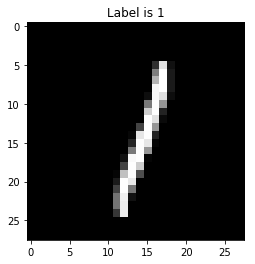

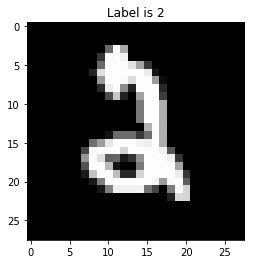

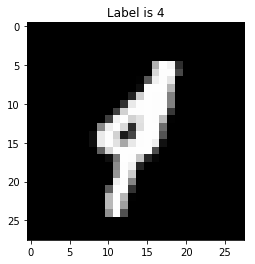

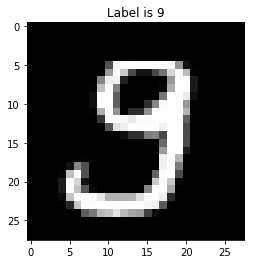

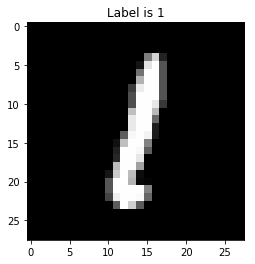

In [5]:
for index in random_indexes:
    label = y_train[index]
    pixels = x_train[index]
    plt.title('Label is {}'.format(label))
    plt.imshow(pixels, cmap='gray')
    plt.show()

In [6]:
# input image dimensions
img_rows, img_cols = 28, 28

### Data transformation

As we are trying to build a CNN, our data should be bi-dimensional, i.e., 28x28 matrices. Also we need to make sure to keep the full dimension of the samples, i.e., one dimesion for the greyscale pixel tone. Depending on the keras settings, the extra dimensions come first or after the image dimensions.

In [7]:
print(K.image_data_format())
if K.image_data_format() == 'channels_first':
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)

channels_last


Now let's reshape our training samples.

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

x_train = x_train.reshape((x_train.shape[0],) + input_shape)
x_test = x_test.reshape((x_test.shape[0],) + input_shape)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

(60000, 28, 28) train samples
(10000, 28, 28) test samples
(60000, 28, 28, 1) train samples
(10000, 28, 28, 1) test samples


The output of the NN will be a probability of the number being guessed is one from 0 to 9, thus we need to change our output to a binary representation of the number, i.e., the output 7 shall be represented as `[0 0 0 0 0 0 0 1 0 0]`. We use a keras helper function named `to_categorical()`.

In [9]:
# convert class vectors to binary class matrices

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


## Specifying the NN

We will start with a very simple NN with a single convolutional feature selector layer.

In [10]:
# number of convolutional filters to use
filters = 32
# size of pooling area for max pooling
pool_size = 2
# convolution kernel size
kernel_size = 3

In [11]:
feature_layers = [
    Conv2D(filters, kernel_size,
           input_shape=input_shape, activation="relu"),
    Conv2D(filters, kernel_size, activation="relu"),
    MaxPooling2D(pool_size),
    Dropout(0.25),
    Flatten(),
]

We then add the classification layers. Firstly with a single 2 neuron layer.

In [12]:
classification_layers = [
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax"),
]

Our model is sequential, as we don't have feedback in it. We instantiate the model with the feature layers and the classification layers together:

In [13]:
model = Sequential(feature_layers + classification_layers)

We can check our model using the `summary()` method.

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               589952    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

After dat we need to compile our model, by setting which optimizer it will use and what are the metrics that we will use for fitting the model.  
A list of optimizers can be found <a href="https://keras.io/optimizers/">here</a>.  
A list of loss functions can be found <a href="https://keras.io/losses/">here</a>.  
A list of metrics can be found <a href="https://keras.io/metrics/">here</a>.  

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

Now we can train our model. We have to specify a few parameters first.  
We have to specify the number of `epochs`, i.e., the number of forward/backpropagation cycles; the `batch_size`, i.e., the number of samples used to train at a time - this parameter optimizes the memory/cache usage. We can also specify a `verbose` parameter to have some feedback while we are training our neural network.

In [ ]:
batch_size = 256
epochs = 3

Now it is training time!

In [ ]:
t = datetime.datetime.now()
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)
print('Training time: %s' % (datetime.datetime.now() - t))

Epoch 1/3
60000/60000 [==============================] - 108s - loss: 0.3536 - acc: 0.8910   
Epoch 2/3
60000/60000 [==============================] - 109s - loss: 0.1074 - acc: 0.9682   
Epoch 3/3
30720/60000 [==============>...............] - ETA: 53s - loss: 0.0833 - acc: 0.9748

Now we should evaluate our model.

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Available metrics are: \n{}".format(model.metrics_names))
print(score)

# The tasks

## 1. Improving the dataset

Neural Networks are known to behave better on normalized datasets. By knowing that there only 256 (from 0 to 255) possible values for the gray scale. How about normalize the dataset?

## 3. Changing the NN topology

Try tweaking the NN topology a bit. Make some small changes in the model:
1. Increase the number of neurons at the hidden layer to `128`.
1. Increase the number of epochs to 3.
1. Add a new 128-neuron `Dense` layer to the classification set of layers.
1. Add another convolutional layer;
1. Add a `MaxPooling` convolutional layer with `pool_size` as the size;
1. Try to use the `categorical_crossentropy` loss function.
1. Try to use the `Adam` optimizer.
1. Add new `Dropout` layers after the `MaxPooling` Layer and the `Dense` Layer(20% is a good start for a dropout).
1. Increase the number of epochs to 5.
